# **Mô hình Random Forest**

## **Thư viện**

In [22]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## **Dữ liệu**

In [23]:
file_path = "..//data//processed//EUR_VND_Exchange_Rate_2020_2025_clean.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


## **Tạo đặc trưng**

In [24]:
def create_lag_features(series, lag=30):
    df_lag = pd.DataFrame()
    for i in range(lag):
        df_lag[f"lag_{i+1}"] = series.shift(i+1)
    df_lag["target"] = series.values
    return df_lag.dropna()

lag = 30
df_lagged = create_lag_features(df['Sell'], lag=lag)


## **Chia train/test**

In [25]:
X = df_lagged.drop(columns="target").values
y = df_lagged["target"].values
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=False, test_size=0.2)
val_timestamps = df_lagged.index[-len(y_val):]


## **Tìm tham số tốt nhất**

In [26]:
def train_rf(X_train, y_train, model_path):
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    joblib.dump(best_model, model_path)
    return best_model


model_path = "../model/RandomForest/best_randomforest.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)


## **Huấn luyện mô hình**

In [27]:
best_model = train_rf(X_train, y_train, model_path)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [28]:
best_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 20,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

## **Đánh giá mô hình**

In [29]:
y_pred = best_model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = mse ** 0.5
mape = (abs((y_val - y_pred) / y_val)).mean() * 100

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape} %")


MAE: 79.3846120264707
MSE: 14697.257471989826
RMSE: 121.23224600736317
MAPE: 0.28329659061904044 %


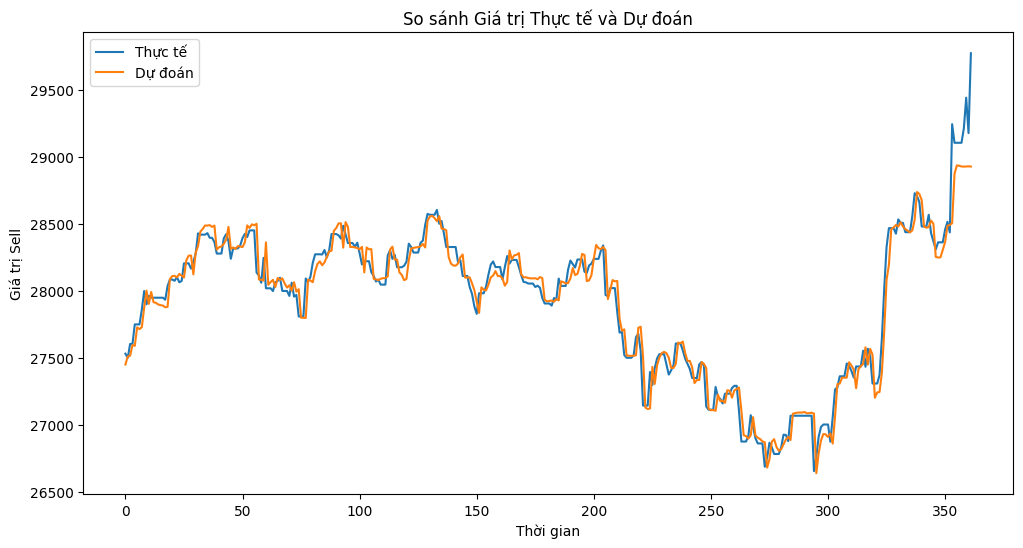

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_val, label="Thực tế")
plt.plot(y_pred, label="Dự đoán")
plt.title("So sánh Giá trị Thực tế và Dự đoán")
plt.xlabel("Thời gian")
plt.ylabel("Giá trị Sell")
plt.legend()
plt.show()


## **Dự đoán 7 ngày tiếp**

In [31]:
last_row = df_lagged.iloc[-1]
last_date = df_lagged.index[-1]
current_lags = last_row.drop('target').values.reshape(1, -1)
predictions = []
prediction_dates = []

for i in range(7):
    pred = best_model.predict(current_lags)[0]
    predictions.append(pred)
    pred_date = last_date + pd.Timedelta(days=i+1)
    prediction_dates.append(pred_date)
    current_lags = np.roll(current_lags, shift=1, axis=1)
    current_lags[0, 0] = pred

df_predictions = pd.DataFrame({
    'Date': prediction_dates,
    'Predicted_Sell': predictions
})
print(df_predictions)

        Date  Predicted_Sell
0 2025-04-12    28929.123821
1 2025-04-13    28895.824158
2 2025-04-14    28882.211342
3 2025-04-15    28879.667684
4 2025-04-16    28881.754601
5 2025-04-17    28910.178449
6 2025-04-18    28921.887870
